# QAT Speed analysis

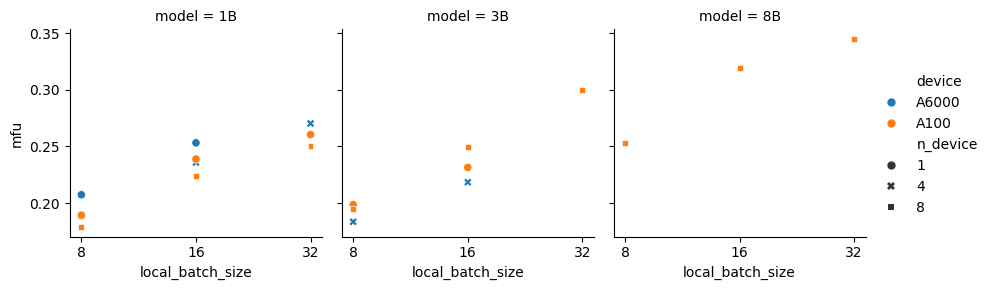

In [1]:
import matplotlib
import pandas as pd
import seaborn as sns

matplotlib.rcParams.update({
    "axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False,
    "figure.figsize": (5, 4),
})


raw_data = {
    # (model, device)
    ("1B", "A6000"): [
        # (batch_size, n_device, time)
        # (4, 1, 1.295),
        (8, 1, 1.890),
        (16, 1, 3.096),
        (32, 1, None),  # OOM
        # (16, 4, 1.499),
        (32, 4, 2.076),
        (64, 4, 3.323),
        (128, 4, 5.800),
    ],
    ("3B", "A6000"): [
        (8, 1, None),  # OOM
        (32, 4, 5.551),
        (64, 4, 9.329),
        (128, 4, None),  # not implemented (needs matmul trick)
    ],
    ("8B", "A6000"): [
        (32, 4, None),  # OOM
    ],
    ("1B", "A100"): [  # 80 GB
        (8, 1, 1.028),
        (16, 1, 1.630),
        (32, 1, 2.990),
        (64, 8, 1.089),
        (128, 8, 1.737),
        (256, 8,  3.112),
    ],
    ("3B", "A100"): [
        (8, 1, 2.548),
        (16, 1, 4.373),
        (32, 1, None),  # OOM
        (64, 8, 2.600),
        (128, 8, 4.063),
        (256, 8,  6.747),
    ],
    ("8B", "A100"): [
        (8, 1, None),  # OOM
        (16, 1, None),  # OOM
        (32, 1, None),  # OOM
        (64, 8, 5.007),
        (128, 8, 7.918),
        (256, 8,  14.662),
    ],
}
sequence_length = 1024
model_parameter_count = {
    "1B": 1235814400,
    "3B": 3212749824,
    "8B": 8030261248,
}
device_flop_per_second = {
    "A6000": 155e12,
    "A100": 312e12,
}
device_bytes_per_second = {  # for reference
    "A6000": 768e9,
    "A100": 2039e9,
}

df = pd.DataFrame.from_records([
    dict(model=model, device=device, batch_size=batch_size, n_device=n_device, time=time)
    for (model, device), rows in raw_data.items()
    for batch_size, n_device, time in rows
])
df["local_batch_size"] = df.batch_size // df.n_device
df["tokens_per_second"] = sequence_length * df.batch_size / df.time
df["flop_per_second"] = 6 * df.tokens_per_second * df.model.apply(model_parameter_count.__getitem__)
df["mfu"] = df.flop_per_second / (df.n_device * df.device.apply(device_flop_per_second.__getitem__))

g = sns.relplot(data=df, y="mfu", x="local_batch_size", hue="device", style="n_device", col="model", height=3)
for ax in g.axes.flatten():
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter("{x:.0f}")
# display(df)